# Sprint 機械学習スクラッチ SVM

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [3]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """
    def __init__(self, num_iter, lr, kernel='linear', gamma=1,
                 theta=0, d=1, threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        # サポートベクトル
        self.s_X = 0
        self.s_y = 0
        # 多項式カーネルのパラメータ
        self.gamma = gamma
        self.theta = theta
        self.d = d
        # パラメーターと予測値の初期化
        self.coef_ = 0
        # yのカテゴリ最大値、最小値の初期化
        self.y_max = 0
        self.y_min = 0
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証用データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
            
        # yの一次元化
        y = y.ravel()
        y_val = y_val.ravel()
        
        # yのカテゴリ最大値、最小値を取得
        self.y_max = y.max()
        self.y_min = y.min()
        
        # yの-1、１化(今回の題材は最大３分類のため、それに対応)
        # サポートベクトルの場合は「０、１」ではなく「−１、１」
        if self.y_max == 2:
            y = np.where(y==2, 1, -1)
            y_val = np.where(y_val==2, 1, -1)
        else:
            y = np.where(y==1, 1, -1)
            y_val = np.where(y_val==1, 1, -1)
        
        # パラメーターの設定（平均０、分散１の正規分布）
        # 微小な方が収束しやすいので「正規分布✖️0.001」
        self.coef_ = np.random.normal(0, 1, X.shape[0])*0.01
        
        for iter_count in range(self.iter):
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print("{}回目の学習".format(iter_count))
            
            # 最急降下法
            # self.coef_の更新
            _gradient_descent(self, X, y)
        
        # ０の要素を除去（推定時に使えるように）
        coef_index = np.where(self.coef_>self.threshold)
        # サポートベクトルの決定
        # 上記のインデックスはタプルのため「Xの２次元目の指定は不要）
        self.coef_ = self.coef_[coef_index]
        self.s_X = X[coef_index]
        self.s_y = y[coef_index]
        
        
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        # カーネルの設定
        if self.kernel=='linear':
            K = np.dot(X, self.s_X.T)
        elif self.kernel=='poly':
            K = self.gamma*((np.dot(X, self.s_X.T) + self.theta)**self.d)
            
        # カテゴリ最大値、最小値に対応させるために分岐
        if self.y_max == 2:
            if self.y_min == 1:
                return np.where(np.dot(K, self.coef_*self.s_y)<0, 1, 2)
            else:
                return np.where(np.dot(K, self.coef_*self.s_y)<0, 0, 2)
        else:
            return  np.where(np.dot(K, self.coef_*self.s_y)<0, 0, 1)

# 【問題1】ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 
λ
 を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。
 
$ \lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})$

In [4]:
def _gradient_descent(self, X, y):
    """
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    
    y : 次の形のndarray, shape (n_samples)
      学習データの結果
      
    self.lam : float
      正則化パラメータ
      
    self.lr : float
      学習率
    
    self.coef_ : 次の形のndarray, shape (n_features)
      Xに対するパラメーター
      
    coef_reg : 次の形のndarray, shape (n_features)
      正則化に用いるパラメーター
    
    self.h0 : 次の形のndarray, shape (n_samples)
      シグモイド関数によるtrainの予測値（過程関数）
    
    Returns
    -------
    self.theta_ : 次の形のndarray, shape (n_samples, 1)
      線形の仮定関数による推定結果
      
    """
    # カーネルの設定
    if self.kernel=='linear':
        K = np.dot(X, X.T)
    elif self.kernel=='poly':
        K = self.gamma*((np.dot(X, X.T) + self.theta)**self.d)
        
    # 傾き
    delta = 1 - y* np.dot(K.T, self.coef_*y)

# forバージョン
#    delta = np.zeros(X.shape[0])
#    for i in range(X.shape[0]):
#         # Kの列とかけるのは、yとcoef_のベクトル：delta[i] = np.sum(self.coef_[i]*y[i]*K[:, i])
#         delta[i] = np.sum(self.coef_*y*K[:, i])
#    delta = 1 - y*delta
        
    # 更新式
    self.coef_ = self.coef_ + self.lr*delta
    
    # self.coef_は０以上のため、０以下の要素は０にする
    self.coef_ = np.where(self.coef_<0, 0, self.coef_)
    
    return

# 【問題2】サポートベクターの決定
計算したラグランジュ乗数 
λ
 が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。


閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

# 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた f(x) の符号が分類結果です。

$f(x) = \sum_{n=1}^{N}\lambda_n y_{sv\_n} k(x, s_n)$

# 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [5]:
from sklearn.datasets import load_iris
iris = load_iris()
X = pd.DataFrame(data=iris.data, columns=iris.feature_names)
y = pd.DataFrame(data=iris.target, columns=['species'])
df = pd.concat([X, y], axis=1)
# 抜き出し
df_2ex =df.query('species == 1 | species == 2')[["sepal length (cm)", "petal length (cm)", 'species']]
X = df_2ex[["sepal length (cm)", "petal length (cm)",]]
y = df_2ex[["species"]]
# ndarray変換
X_array = X.values
# yに関して一次元化（グラフ化で必要）
y_array = np.ravel(y.values)
# 分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X_array, y_array, test_size=0.25, random_state=0)
# 標準化
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)

In [57]:
# 学習

# _init__(self, num_iter, lr, kernel='linear', gammma=1,
#                  theta=0, d=1, threshold=1e-5, verbose=False):
ssvc = ScratchSVMClassifier(5000, 0.01, threshold=1e-5)
ssvc.fit(X_train_std, y_train, X_valid_std, y_valid)
y_valid_predict = ssvc.predict(X_valid_std)

In [58]:
# 正解率
print("正解率：", accuracy_score(y_valid, y_valid_predict))
# 適合率
print("適合率：", precision_score(y_valid, y_valid_predict))
# Recall（再現率）
print("再現率：", recall_score(y_valid, y_valid_predict))
# F値
print("F値：", f1_score(y_valid, y_valid_predict))
# 混同行列
print("混同行列\n", confusion_matrix(y_valid, y_valid_predict))

正解率： 0.92
適合率： 0.9230769230769231
再現率： 0.9230769230769231
F値： 0.9230769230769231
混同行列
 [[12  1]
 [ 1 11]]


# 【問題5】決定領域の可視化
決定領域を可視化してください。


以下の例のようにサポートベクターは異なる色で示してください。

In [59]:
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel',
                    ylabel='ylabel', target_names=['setosa', 'versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['green', 'red', 'blue']
    contourf_color = ['white', 'pink', 'skyblue']
    # クラスの長さをクラス数
    n_class = len(set(y))

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step),
                                    np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    
    # contourf_color、scatter_color、target_namesをクラス数に応じて変化
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap([contourf_color[n] for n in set(y)]))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80,
                    color=scatter_color[target],label=target_names[target], marker='o')
    # サポートベクトルと切り分け
    plt.scatter(model.s_X[:, 0],
                model.s_X[:, 1], s=80,  marker='o', color='y')
    
    patches = [mpatches.Patch(color=scatter_color[n], label=target_names[n]) for n in set(y)]
    plt.legend(handles=patches)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.legend()
    plt.show()

In [60]:
ssvc.coef_

array([71.37239   , 14.76226681, 36.75679169, 29.27900156, 54.25510837,
       21.35552362,  9.74980293, 58.22854039, 32.7622319 , 51.64176546,
       23.75053649])

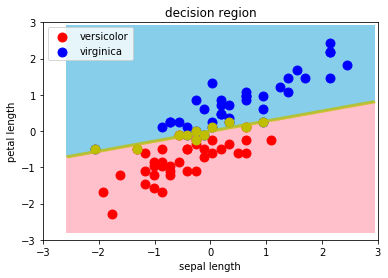

In [61]:
decision_region(X_train_std, y_train, model=ssvc, step=0.01, title='decision region',
                xlabel="sepal length", ylabel="petal length")

# 【問題6】（アドバンス課題）多項式カーネル関数の作成
最初に作成した実装では線形カーネルを使用していました。多項式カーネルにも切り替えられるようにしましょう。

線形カーネル
$k(x_i, x_j) = x_{i}^{T} x_j$

多項式カーネル
$k(x_i, x_j) = \gamma(x_{i}^{T} x_j + \theta_0)^{d}$

In [31]:
ssvc_poly = ScratchSVMClassifier(5000, 0.001,
                                 kernel='poly', gamma=0.25, theta=2, d=3, threshold=1e-5)
ssvc_poly.fit(X_train_std, y_train, X_valid_std, y_valid)
y_valid_predict_poly = ssvc_poly.predict(X_valid_std)

# 正解率
print("正解率：", accuracy_score(y_valid, y_valid_predict_poly))
# 適合率
print("適合率：", precision_score(y_valid, y_valid_predict_poly))
# Recall（再現率）
print("再現率：", recall_score(y_valid, y_valid_predict_poly))
# F値
print("F値：", f1_score(y_valid, y_valid_predict_poly))
# 混同行列
print("混同行列\n", confusion_matrix(y_valid, y_valid_predict_poly))

正解率： 0.92
適合率： 1.0
再現率： 0.8461538461538461
F値： 0.9166666666666666
混同行列
 [[11  2]
 [ 0 12]]


In [32]:
ssvc_poly.coef_

array([2.07455411, 5.38803508, 0.31386823, 6.46437473, 0.66750539,
       0.33942762, 3.26890679, 1.29370864, 2.6683679 , 0.26455975,
       5.6918668 , 2.84878033, 4.70971615, 0.21022769, 1.46437941])

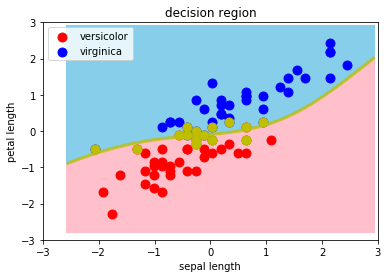

In [33]:
decision_region(X_train_std, y_train, model=ssvc_poly, step=0.01, title='decision region',
                xlabel="sepal length", ylabel="petal length")